# Data preprocessing

In [2]:
# <api>
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
# <api>
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [4]:
# <api>
# https://github.com/albu/albumentations
from albumentations import (ToFloat, Resize,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose
)

In [5]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorboardX import SummaryWriter

In [6]:
# <api>
path = './airbus/'
path_train = path + 'train/'
path_test = path + 'test/'

In [7]:
# <api>
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [8]:
# <api>
# ref: https://www.kaggle.com/leighplt/pytorch-tutorial-dataset-data-preparetion-stage
# ref: https://www.kaggle.com/kmader/transfer-learning-for-boat-or-no-boat
# ref: https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection

# This dataset is only for training and validating on TRAIN data, because there was a big failure
# whith the TEST data and it should be updated and uploaded somewhere in the future.
# So this class should be also updated for the submission.
class AirbusDS(object):
    """
    A customized data loader.
    """
    def __init__(self, root, aug=False, resize_factor=1, empty_frac=0.33, test_size=0.1):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.aug = aug
        self.path_train = root + 'train/'
        # TODO: exclude corrupt images
        exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images        
    
        # Calculate masks
        masks = pd.read_csv(str(self.root+'train_ship_segmentations.csv')).fillna(-1)
        masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
        
        # Calculate the number of ships on the images
        unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
        unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
        unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
        
        # Drop corrupted images
        unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
        
        # Split dataset to train and validate sets to evaluate the model
        train_ids, val_ids = train_test_split(unique_img_ids, test_size=test_size)
        self.val_ids = val_ids
        
        # Drop small images (mostly just clouds, water or corrupted)
        train_ids['file_size_kb'] = train_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)
        train_ids = train_ids[train_ids['file_size_kb']>40] # keep only >40kb files
        
        # Undersample empty images to balance the dataset
        ships = train_ids[train_ids['has_ship']==1] 
        no_ships = train_ids[train_ids['has_ship']==0].sample(frac=empty_frac)  # Take only this fraction of empty images
        self.train_ids = pd.concat([ships, no_ships], axis=0)
        
        masks.drop(['ships'], axis=1, inplace=True)
        self.masks = masks        
        
        # Define transformations for augmentation and without it
        self.transform_no_aug = transforms.Compose([transforms.Resize((int(768/resize_factor), int(768/resize_factor))),
                                                 transforms.ToTensor()])
        if self.aug:
            self.transform = Compose([Resize(height=int(768/resize_factor), width=int(768/resize_factor)),
                                      OneOf([RandomRotate90(), Transpose(), Flip()], p=0.3)])
        else:
            self.transform = self.transform_no_aug                                                 
        
    def get_ds(self):
        return AirbusDS_train(self.path_train, self.aug, self.transform, self.train_ids, self.masks),\
               AirbusDS_val(self.path_train, False, self.transform_no_aug, self.val_ids, self.masks)        
    

In [9]:
# <api>
class AirbusDS_train(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path_train, aug, transform, ids, masks):
        """ Intialize the dataset
        """
        self.aug = aug
        self.path_train = path_train
        self.transform = transform
        self.df = ids
        self.masks = masks       
        self.filenames = self.df['ImageId'].values
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks
        for mask in img_masks:
            all_masks += rle_decode(mask)
        return all_masks
    
    def get_label(self, ImageId):
        '''Returns a label: 0 - no ship, 1 - has one or more ships.'''
        label = int(self.df[self.df['ImageId']==ImageId]['has_ship'].values[0])
        return label
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
        mask = self.get_mask(ImageId)            
        if self.aug:
            data = {"image": np.array(image), "mask": mask}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, transformed['mask'][np.newaxis,:,:], label
        else:
        
            return self.transform(image), mask[np.newaxis,:,:], label 

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [10]:
# <api>
class AirbusDS_val(AirbusDS_train):
    """
    A customized data loader.
    """
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
                    
        if self.aug:
            data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, label
        else:
            return self.transform(image), label

In [13]:
# <api>
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Example of how it works

tensor([ 1,  1,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,
         1,  1,  0,  1,  1,  1,  1,  1,  0,  0])


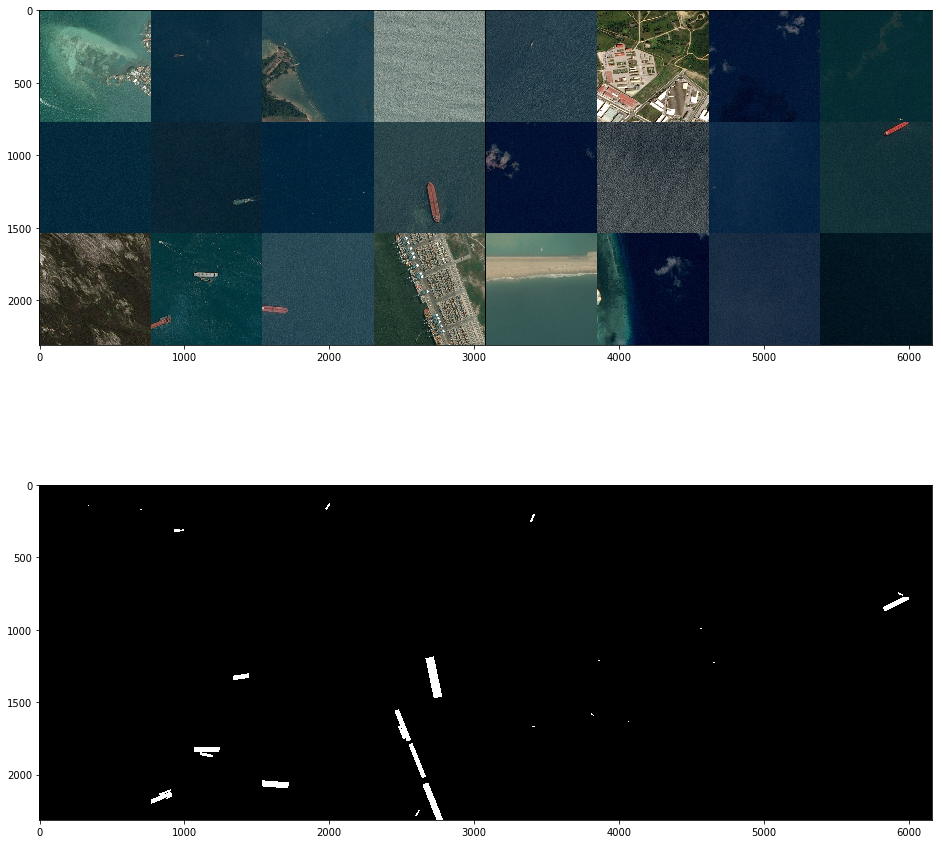

In [14]:
airimg = AirbusDS(path, aug=True, resize_factor=1, empty_frac=0.5, test_size=0.1)
airimg_train, airimg_val = airimg.get_ds()
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(airimg_train, batch_size=24, shuffle=True, num_workers=0)

# get some images
dataiter = iter(trainloader)
images, masks, labels = dataiter.next()

# show images
plt.figure(figsize=(16,16))
plt.subplot(211)
imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
imshow(torchvision.utils.make_grid(masks))
print(labels)

In [15]:
print('Train size: ', len(airimg_train.filenames))

Train size:  59814


GroundTruth:  tensor([ 0,  1,  0,  1,  0,  0,  0,  0])
Validation size:  10407


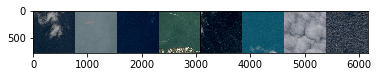

In [16]:
valloader = D.DataLoader(airimg_val, batch_size=8, shuffle=True, num_workers=0)

dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', labels)
print('Validation size: ', len(airimg_val.filenames))

# Some calculations and histograms from the datset

In [17]:
masks = pd.read_csv(str(path+'train_ship_segmentations.csv'))

In [18]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [19]:
unique_img_ids.shape

(104070, 4)

In [20]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images 


In [21]:
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
unique_img_ids.shape

(104069, 4)

In [22]:
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>40] # keep only >40kb files
ships = unique_img_ids[unique_img_ids['has_ship']==1]
no_ships = unique_img_ids[unique_img_ids['has_ship']==0].sample(frac=0.3)  #take only frac of empty images
files = pd.concat([ships, no_ships], axis=0)

masks.drop(['ships'], axis=1, inplace=True)

In [23]:
no_ships.shape[0]

22444

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026414652D68>,
      dtype=object)

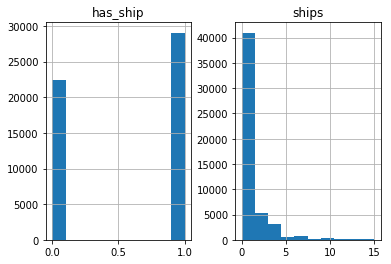

In [24]:
files[['ships', 'has_ship']].hist()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_gpu = torch.cuda.is_available()
batch_size = 4
workers = 4
aug=True
resize_factor=4
empty_frac=0.3
test_size=0.1

In [28]:
# Implementation from https://github.com/timctho/unet-pytorch/
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

In [29]:
# Define optimizer and loss function (criterion)
model = UNet().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

# we can use advanced stochastic gradient descent algorithms 
# with regularization (weight-decay) or momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                            momentum=0.9,
                            weight_decay=5e-4)

In [30]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(outputs, targets):
    """
    Evaluates a model's top k accuracy

    Parameters:
        outputs (torch.autograd.Variable): model output
        targets (torch.autograd.Variable): ground-truths/labels
        

    Returns:
        float: percentage of correct predictions
    """

    batch_size = targets.size(0)

    _, pred = torch.max(outputs.data, 1)
    correct = (pred == targets).sum().item()

    res = 100 * correct / batch_size
    return res

In [31]:
def train(train_loader, model, criterion, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    for i, data in enumerate(train_loader):
        inputs, masks, targets = data
        inputs = inputs.to(device).float()
        targets = targets.to(device).long()
        

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #prec1 = accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        #top1.update(prec1, inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if i % 1000 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(loss=losses))

In [36]:
total_epochs = 1
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(trainloader, model, criterion, optimizer, device)
    print("VALIDATION")
    validate(valloader, model, criterion, device)

EPOCH: 1
TRAIN


RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at c:\users\administrator\downloads\new-builder\win-wheel\pytorch\aten\src\thnn\generic/SpatialClassNLLCriterion.c:60

In [33]:
trainloader = D.DataLoader(airimg_train, batch_size=1, shuffle=True, num_workers=0)

In [34]:
valloader = D.DataLoader(airimg_val, batch_size=1, shuffle=True, num_workers=0)